In [ ]:
!!pip install -q --upgrade keras-hub
!!pip install -q --upgrade keras  # Upgrade to Keras 3.

['\x1b[?25l   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/1.3 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K   \x1b━━━━━\x1b\x1b╺\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.2/1.3 MB\x1b \x1b6.4 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b\x1b╸\x1b\x1b━━━━\x1b \x1b1.2/1.3 MB\x1b \x1b18.4 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b\x1b╸\x1b \x1b1.3/1.3 MB\x1b \x1b18.3 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b1.3/1.3 MB\x1b \x1b12.3 MB/s\x1b eta \x1b0:00:00\x1b',
 "\x1b[?25h\x1bERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.",
 'keras-nlp 0.18.1 requires keras-hub==0.18.1, but you have keras-hub 0.19.1 which is incompatible.\x1b\x1b',
 '\x1b']

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import json
import math
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import losses
from keras import ops
from keras import optimizers
from keras.optimizers import schedules
from keras import metrics
from keras.applications.imagenet_utils import decode_predictions
import keras_hub

# Import tensorflow for [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) and its preprocessing functions
import tensorflow as tf
import tensorflow_datasets as tfds

#Beginner

In [ ]:
classifier = keras_hub.models.ImageClassifier.from_preset("resnet_v2_50_imagenet")

100%|██████████| 840/840 [00:00<00:00, 382kB/s]


100%|██████████| 3.54k/3.54k [00:00<00:00, 5.30MB/s]


100%|██████████| 98.1M/98.1M [00:01<00:00, 66.5MB/s]


100%|██████████| 90.2M/90.2M [00:01<00:00, 51.0MB/s]


In [ ]:
def plot_image_gallery(images, titles=None, num_cols=3, figsize=(6, 12)):
    num_images = len(images)
    images = np.asarray(images) / 255.0
    images = np.minimum(np.maximum(images, 0.0), 1.0)
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, squeeze=False)
    axes = axes.flatten()  # Flatten in case the axes is a 2D array

    for i, ax in enumerate(axes):
        if i < num_images:
            # Plot the image
            ax.imshow(images[i])
            ax.axis("off")  # Remove axis
            if titles and len(titles) > i:
                ax.set_title(titles[i], fontsize=12)
        else:
            # Turn off the axis for any empty subplot
            ax.axis("off")

    plt.show()
    plt.close()

309830/309830 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


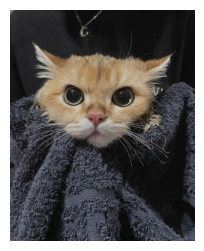

In [ ]:
filepath = keras.utils.get_file(
    origin="https://upload.wikimedia.org/wikipedia/commons/thumb/4/49/5hR96puA_VA.jpg/1024px-5hR96puA_VA.jpg"
)
image = keras.utils.load_img(filepath)
image = np.array([image])
plot_image_gallery(image, num_cols=1, figsize=(3, 3))

In [ ]:
predictions = classifier.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
print(f"Top two classes are:\n{decode_predictions(predictions, top=2)}")

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Top two classes are:
[[('n02123394', 'Persian_cat', -1.3963698), ('n02808304', 'bath_towel', -2.0231369)]]


# Intermediate

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


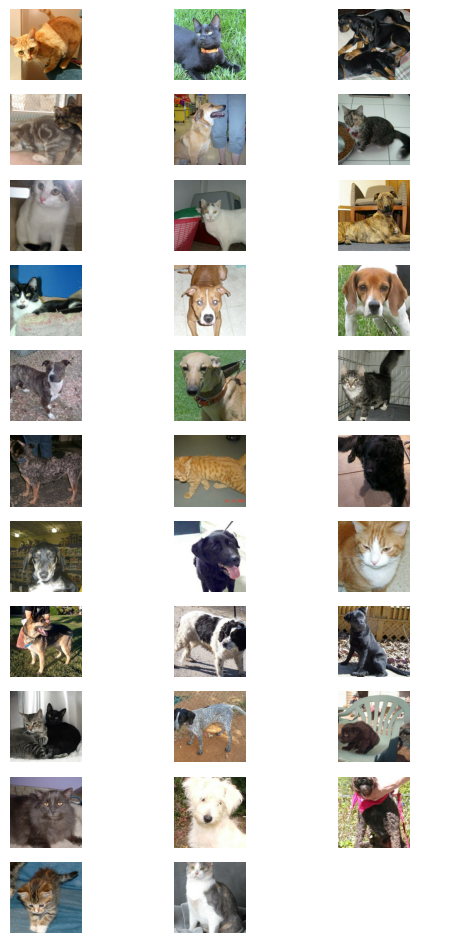

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()

data, dataset_info = tfds.load("cats_vs_dogs", with_info=True, as_supervised=True)
train_steps_per_epoch = dataset_info.splits["train"].num_examples // BATCH_SIZE
train_dataset = data["train"]

num_classes = dataset_info.features["label"].num_classes

resizing = keras.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)


def preprocess_inputs(image, label):
    image = tf.cast(image, tf.float32)
    # Staticly resize images as we only iterate the dataset once.
    return resizing(image), tf.one_hot(label, num_classes)


# Shuffle the dataset to increase diversity of batches.
# 10*BATCH_SIZE follows the assumption that bigger machines can handle bigger
# shuffle buffers.
train_dataset = train_dataset.shuffle(
    10 * BATCH_SIZE, reshuffle_each_iteration=True
).map(preprocess_inputs, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

images = next(iter(train_dataset.take(1)))[0]
plot_image_gallery(images)

In [ ]:
model = keras_hub.models.ImageClassifier.from_preset(
    "resnet_v2_50_imagenet", num_classes=2
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

In [ ]:
model.fit(train_dataset)


In [ ]:
predictions = model.predict(image)

classes = {0: "cat", 1: "dog"}
print("Top class is:", classes[predictions[0].argmax()])

# Advanced

In [ ]:
BATCH_SIZE = 32
NUM_CLASSES = 101
IMAGE_SIZE = (224, 224)

# Change epochs to 100~ to fully train.
EPOCHS = 1


def package_inputs(image, label):
    return {"images": image, "labels": tf.one_hot(label, NUM_CLASSES)}


train_ds, eval_ds = tfds.load(
    "caltech101", split=["train", "test"], as_supervised="true"
)
train_ds = train_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(BATCH_SIZE * 16)
augmenters = []

In [ ]:
resize = keras.layers.Resizing(*IMAGE_SIZE, crop_to_aspect_ratio=True)
train_ds = train_ds.map(resize)
eval_ds = eval_ds.map(resize)

train_ds = train_ds.batch(BATCH_SIZE)
eval_ds = eval_ds.batch(BATCH_SIZE)

batch = next(iter(train_ds.take(1)))
image_batch = batch["images"]
label_batch = batch["labels"]

plot_image_gallery(
    image_batch,
)

In [ ]:
random_flip = keras.layers.RandomFlip()
augmenters += [random_flip]

image_batch = random_flip(image_batch)
plot_image_gallery(image_batch)

In [ ]:
crop = keras.layers.RandomCrop(
    int(IMAGE_SIZE[0] * 0.9),
    int(IMAGE_SIZE[1] * 0.9),
)

augmenters += [crop]

image_batch = crop(image_batch)
plot_image_gallery(
    image_batch,
)

In [ ]:
rotate = keras.layers.RandomRotation((-45 / 360, 45 / 360))

augmenters += [rotate]

image_batch = rotate(image_batch)
plot_image_gallery(image_batch)

resize = keras.layers.Resizing(*IMAGE_SIZE, crop_to_aspect_ratio=True)
augmenters += [resize]

image_batch = resize(image_batch)
plot_image_gallery(image_batch)

In [ ]:
def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs["images"] = augmenter(inputs["images"])
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)
train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)

image_batch = next(iter(train_ds.take(1)))["images"]
plot_image_gallery(
    image_batch,
)

#Expert

In [ ]:
inference_resizing = keras.layers.Resizing(*IMAGE_SIZE, crop_to_aspect_ratio=True)


def do_resize(inputs):
    inputs["images"] = inference_resizing(inputs["images"])
    return inputs


eval_ds = eval_ds.map(do_resize, num_parallel_calls=tf.data.AUTOTUNE)

image_batch = next(iter(eval_ds.take(1)))["images"]
plot_image_gallery(
    image_batch,
)

In [ ]:
def unpackage_dict(inputs):
    return inputs["images"], inputs["labels"]


train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
def lr_warmup_cosine_decay(
    global_step,
    warmup_steps,
    hold=0,
    total_steps=0,
    start_lr=0.0,
    target_lr=1e-2,
):
    # Cosine decay
    learning_rate = (
        0.5
        * target_lr
        * (
            1
            + ops.cos(
                math.pi
                * ops.convert_to_tensor(
                    global_step - warmup_steps - hold, dtype="float32"
                )
                / ops.convert_to_tensor(
                    total_steps - warmup_steps - hold, dtype="float32"
                )
            )
        )
    )

    warmup_lr = target_lr * (global_step / warmup_steps)

    if hold > 0:
        learning_rate = ops.where(
            global_step > warmup_steps + hold, learning_rate, target_lr
        )

    learning_rate = ops.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, total_steps, hold, start_lr=0.0, target_lr=1e-2):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(
            global_step=step,
            total_steps=self.total_steps,
            warmup_steps=self.warmup_steps,
            start_lr=self.start_lr,
            target_lr=self.target_lr,
            hold=self.hold,
        )
        return ops.where(step > self.total_steps, 0.0, lr)


In [ ]:
total_images = 9000
total_steps = (total_images // BATCH_SIZE) * EPOCHS
warmup_steps = int(0.1 * total_steps)
hold_steps = int(0.45 * total_steps)
schedule = WarmUpCosineDecay(
    start_lr=0.05,
    target_lr=1e-2,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    hold=hold_steps,
)
optimizer = optimizers.SGD(
    weight_decay=5e-4,
    learning_rate=schedule,
    momentum=0.9,
)

In [ ]:
backbone = keras_hub.models.ResNetBackbone(
    input_conv_filters=[64],
    input_conv_kernel_sizes=[7],
    stackwise_num_filters=[64, 64, 64],
    stackwise_num_blocks=[2, 2, 2],
    stackwise_num_strides=[1, 2, 2],
    block_type="basic_block",
)
model = keras.Sequential(
    [
        backbone,
        keras.layers.GlobalMaxPooling2D(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(101, activation="softmax"),
    ]
)

In [ ]:
loss = losses.CategoricalCrossentropy(label_smoothing=0.1)

In [ ]:
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[
        metrics.CategoricalAccuracy(),
        metrics.TopKCategoricalAccuracy(k=5),
    ],
)

In [ ]:
model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=eval_ds,
)